In [63]:
# Download packages
import pandas as pd
pd.set_option('display.max_columns',250)

import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
import re
import string

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from google.cloud import bigquery
# version conflict, needs to be google-cloud = 0.26.1

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from io import StringIO
from IPython.display import display
import os


In [64]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '~/.config/gcloud/application_default_credentials.json'

In [65]:
credential_path = "/Users/audreychu/Desktop/projects/reddit/reddit AITA-55c7ff53d5ec.json"
# credential_path = "/home/jeremy/Desktop/projects/reddit/reddit AITA-2991631ea459.json"
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = credential_path

client = bigquery.Client()

In [69]:
QUERY = (""" SELECT * FROM fh-bigquery.reddit_posts.2019_08 WHERE subreddit = 'AmItheAsshole' and score > 10 and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_07`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2 

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_06`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_05`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_04`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_03`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_02`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2

        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2019_01`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_12`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_11`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_10`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
        
        UNION DISTINCT

        SELECT * 
        FROM `fh-bigquery.reddit_posts.2018_09`
        WHERE subreddit = 'AmItheAsshole'
        and score > 10
        and num_comments > 2
    """)


In [70]:
# API request
query_job = client.query(QUERY)

In [71]:
# Waits for query to finish
rows = query_job.result()
for row in rows:
    print(row.name)
df = query_job.to_dataframe()
df.shape

None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None
None


(39354, 33)

In [47]:
df.to_pickle('reddit_aita_2019_08.pickle')

In [48]:
df = pd.read_pickle('reddit_aita_2019_08.pickle')

In [49]:
df['title_length'] = [len(x.split()) for x in df['title']]
df['post_length'] = [len(x.split()) for x in df['selftext']]

In [50]:
df.head()

,created_utc,subreddit,author,domain,url,num_comments,score,ups,downs,title,selftext,saved,id,from_kind,gilded,from,stickied,retrieved_on,over_18,thumbnail,subreddit_id,hide_score,link_flair_css_class,author_flair_css_class,archived,is_self,from_id,permalink,name,author_flair_text,quarantine,link_flair_text,distinguished,title_length,post_length
0,1537975058,AmItheAsshole,stonerplumber,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,125,1110,None,None,AITA stuck acquaintance with drinks they order...,Drinking with a few friends and an acqaintance...,None,9j3f1i,None,0,None,False,1540178088,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/9j3f1i/aita_stuck_ac...,None,None,False,not the a-hole,None,10,130
1,1546763247,AmItheAsshole,sams2011,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,12,16,None,None,AITA for beeing mad that my boyfriend doesn't ...,This is my first post ever and I'm not a nativ...,None,ad3vms,None,0,None,False,1552596228,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/ad3vms/aita_for_beei...,None,None,False,Not the A-hole,None,13,467
2,1546306476,AmItheAsshole,Super-WeinyHutJunioR,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,38,17,None,None,AITA if I want to instill a fear of flying int...,"That’s it, self explanatory, I am deathly afra...",None,abdo6m,None,0,None,False,1552567064,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/abdo6m/aita_if_i_wan...,None,None,False,Asshole,None,18,161
3,1546314083,AmItheAsshole,Unicornbreakwind,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,13,19,None,None,WIBTA if I threw a pile of tree limbs into my ...,"To give some background, the houses in my neig...",None,abeli5,None,0,None,False,1552567506,False,self,t5_2xhvq,None,ass,None,False,True,None,/r/AmItheAsshole/comments/abeli5/wibta_if_i_th...,None,None,False,Asshole,None,13,295
4,1548477365,AmItheAsshole,YouEnnSee,self.AmItheAsshole,https://www.reddit.com/r/AmItheAsshole/comment...,16,11,None,None,AITA for not donating to a funeral Go-Fund-Me?,A really close friend of mine had a friend pas...,None,ajxrku,None,0,None,False,1552711662,False,self,t5_2xhvq,None,not,None,False,True,None,/r/AmItheAsshole/comments/ajxrku/aita_for_not_...,None,None,False,Not the A-hole,None,8,146


In [51]:
# these stats are only for posts with at least 10 net upvotes and 2 comments as per data pull
# Audrey to change what is pulled
df.describe()

,created_utc,num_comments,score,gilded,retrieved_on,title_length,post_length
count,3.935400e+04,39354.000000,39354.000000,39354.000000,3.935400e+04,39354.000000,39354.000000
mean,1.557060e+09,145.459674,581.060832,0.017254,1.561065e+09,12.709737,258.386339
std,7.116522e+06,390.783393,2508.130847,0.214657,6.426437e+06,5.134729,223.506395
min,1.535763e+09,3.000000,11.000000,0.000000,1.540057e+09,1.000000,0.000000
25%,1.552461e+09,25.000000,17.000000,0.000000,1.560187e+09,9.000000,1.000000
50%,1.558113e+09,44.000000,39.000000,0.000000,1.560953e+09,12.000000,241.000000
75%,1.563108e+09,102.000000,175.000000,0.000000,1.566722e+09,15.000000,407.000000
max,1.567295e+09,10655.000000,66384.000000,20.000000,1.567381e+09,64.000000,2666.000000


In [52]:
len(df)

39354

In [53]:
# pretty massive amount of posts with basically zero engagement
# Take upper quartile of posts for more substantive dataset
aita = df.loc[(df['score']>= 25) & (df['num_comments'] >= 5)].copy()


# cutting some of the uncommon labels.. might want to leave them in?
# df['link_flair_text'].value_counts()
# aita = aita[aita['link_flair_text'].isin(['Not the A-hole','Asshole','No A-holes here','Everyone Sucks'])]
aita = aita[aita['link_flair_text'].isin(['Not the A-hole','Asshole'])]

# create 'label_id' with encoded categories
aita['label_id'] = aita['link_flair_text'].factorize()[0]

# why?
label_id_df = aita[['link_flair_text','label_id']].drop_duplicates()

# dictionaries for future use
label_to_id = dict(label_id_df.values)
id_to_label = dict(label_id_df[['label_id','link_flair_text']].values)

print(label_to_id)

aita.shape

{'Not the A-hole': 0, 'Asshole': 1}


(17034, 36)

In [54]:
# most values are overwhelmingly NTA
aita['link_flair_text'].value_counts()

Not the A-hole    12659
Asshole            4375
Name: link_flair_text, dtype: int64

Text(0.5, 1.0, 'Score')

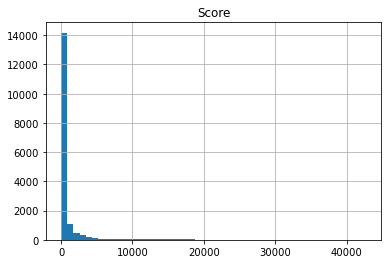

In [56]:
aita['score'].hist(bins=50);
plt.title('Score')

Text(0.5, 1.0, 'Number of Comments')

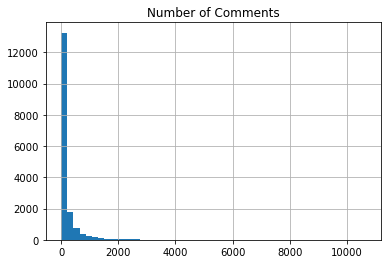

In [57]:
aita['num_comments'].hist(bins=50);
plt.title('Number of Comments')

### Who was the biggest asshole?

In [58]:
aita_big = aita.sort_values(by='score',ascending=False)
aita_big = aita_big[aita_big['link_flair_text']=='Asshole']
aita_big['author'].iloc[0]

'aljsdhnrthrow'

In [59]:
aita_big['selftext'].iloc[0]

'\nThrowaway because husband told me I was TA and want to know before I get home and argue. On phone format is bad.\n\nI was in a higher end department store today (rhymes with loomingtales) and happened to end up next to two teenage aged girls while shopping. One of the girls had picked out a pair of VERY expensive boots and they were both fawning over them. Second girl must have looked at price tag and asks boots girl if she’s really gonna spend that much on boots. Girl with boots says something along the lines of “it’s fine I have my dads credit card I’m not paying ” which instantly caught my attention because THATS NOT HER CARD. I’ve told my son multiple times he’s never allowed to use my card so I’m interested to see how this girl thinks she’s going to get away with fraud but had split up from the girls at this point because they had found something else.\n\nWe end up at the same register (me behind) and I see her total hit well over four digits. The girl is about to swipe her car

In [60]:
def preprocess(sentence):
    sentence = sentence.lower()
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    filtered_words = [w for w in tokens if not w in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(w) for w in filtered_words]
    return " ".join(lemmas)

In [61]:
aita['proc_title'] = [x.lower() for x in aita['title']]
aita['proc_title'] = [s.translate(string.punctuation) for s in aita['proc_title']]

In [62]:
aita['proc_title'] = [preprocess(x) for x in aita['title']]
aita['proc_text'] = [preprocess(x) for x in aita['selftext']]

aita['proc_title'] = [x.replace('aita', '') for x in aita['proc_title']]
aita['proc_title'] = [x.replace('wibta', '') for x in aita['proc_title']]
# x200b
aita['proc_text'] = [x.replace('aita', '') for x in aita['proc_text']]
aita['proc_text'] = [x.replace('wibta', '') for x in aita['proc_text']]
aita['proc_title'] = [x.replace('asshole', '') for x in aita['proc_title']]
aita['proc_text'] = [x.replace('asshole', '') for x in aita['proc_text']]

In [ ]:
# nltk.download('wordnet')

In [ ]:
aita.sort_values('num_comments', ascending = False, inplace = True)

In [ ]:
aita['link_flair_text'].value_counts()

In [ ]:
asshole_text = " ".join(aita.loc[(aita['label_id'] == 0)]['proc_text'])
nta_text = " ".join(aita.loc[(aita['label_id'] == 1)]['proc_text'])
na_text = " ".join(aita.loc[(aita['label_id'] == 2)]['proc_text'])
es_text = " ".join(aita.loc[(aita['label_id'] == 3)]['proc_text'])

In [ ]:
wordcloud = WordCloud( background_color="white").generate(asshole_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Asshole Wordcloud')
plt.show()

In [ ]:
wordcloud = WordCloud( background_color="white").generate(nta_text)

# Display the generated image:
plt.figure(figsize = (15, 15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Not The Asshole Wordcloud')
plt.show()

In [ ]:
aita.describe()

In [ ]:
len(aita)

In [ ]:
aita['link_flair_text'].value_counts()

#### Terms
Score: the number of upvotes minus the number of downvotes.